In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee


In [2]:
import models
import experiment as exp

In [3]:
from importlib import reload
_ = reload(models)
_ = reload(exp)


## Example:

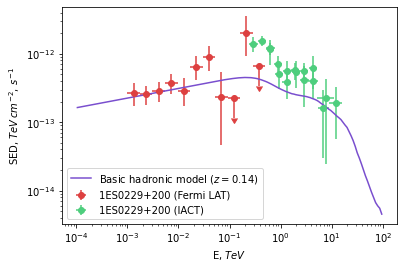

In [4]:
obj = exp.Object.by_name('1ES0229+200')
model = models.BasicHadronicModelSED.at_z(obj.z)

fig, ax = plt.subplots(figsize=(6, 4))

obj.plot(ax)
model.plot(ax)

ax.legend()
plt.show()

# Posterior for a single object (test)

In [10]:
# logposterior = exp.Object.by_name('1ES0229+200').get_joint_logposterior(model)

# def logposterior_single_arg(theta):
#     return logposterior(*theta)


# n_walkers = 512
# n_dim = 3
# sampler = emcee.EnsembleSampler(n_walkers, n_dim, logposterior_single_arg)

# theta_estimation = np.ones(shape=(n_dim,), dtype=float)
# theta_starting_point_log_sigmas = [0.05, 0.05, 0.05]

# starting_points = np.tile(theta_estimation, (n_walkers, 1))
# for i, sigma in enumerate(theta_starting_point_log_sigmas):
#     starting_points[:, i] = np.exp(np.random.normal(loc=0, scale=np.log(1 + sigma), size=(n_walkers,)))

# sampler.run_mcmc(starting_points, 3000, progress=True)

# Joint posterior for all objects

In [5]:
object_logposteriors = [obj.get_joint_logposterior(model) for obj in exp.all_objects]

def all_objects_logposterior(theta):
    E_factor_1, E_factor_2, *normalizations = theta
    logp = 0
    for obj_logposterior, normalization in zip(object_logposteriors, normalizations):
        logp += obj_logposterior(normalization, E_factor_1, E_factor_2)
        if np.isinf(logp):
            return -np.inf
    return logp


In [6]:
n_walkers = 512
n_dim = 2 + len(exp.all_objects)
sampler = emcee.EnsembleSampler(n_walkers, n_dim, all_objects_logposterior)

In [7]:
theta_estimation = np.ones(shape=(n_dim,), dtype=float)
theta_starting_point_log_sigmas = [0.1, 0.1] + [0.5] * len(exp.all_objects)

starting_points = np.tile(theta_estimation, (n_walkers, 1))
for i, sigma in enumerate(theta_starting_point_log_sigmas):
    starting_points[:, i] = np.exp(np.random.normal(loc=0, scale=np.log(1 + sigma), size=(n_walkers,)))

In [8]:
_ = sampler.run_mcmc(starting_points, 3000, progress=True)

  0%|          | 0/3000 [00:00<?, ?it/s]/home/njvh/Documents/Science/gamma/kill-basic-hadronic-model/kbhmenv/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 3000/3000 [01:29<00:00, 33.53it/s]


In [9]:
np.mean(sampler.acceptance_fraction)

0.35467708333333337

# Sampling results

In [14]:
taus = sampler.get_autocorr_time(tol=0)
if np.all(np.isnan(taus)):
    print('unable to calculate tau, setting manually')
    tau = 200
else:
    tau = int(np.mean(taus[np.isfinite(taus)]))
print(f'tau = {tau}')

unable to calculate tau, setting manually
tau = 200


In [92]:
sample = sampler.get_chain(flat=True, thin=tau, discard=tau * 5)

print(sample.shape)

(5120, 7)


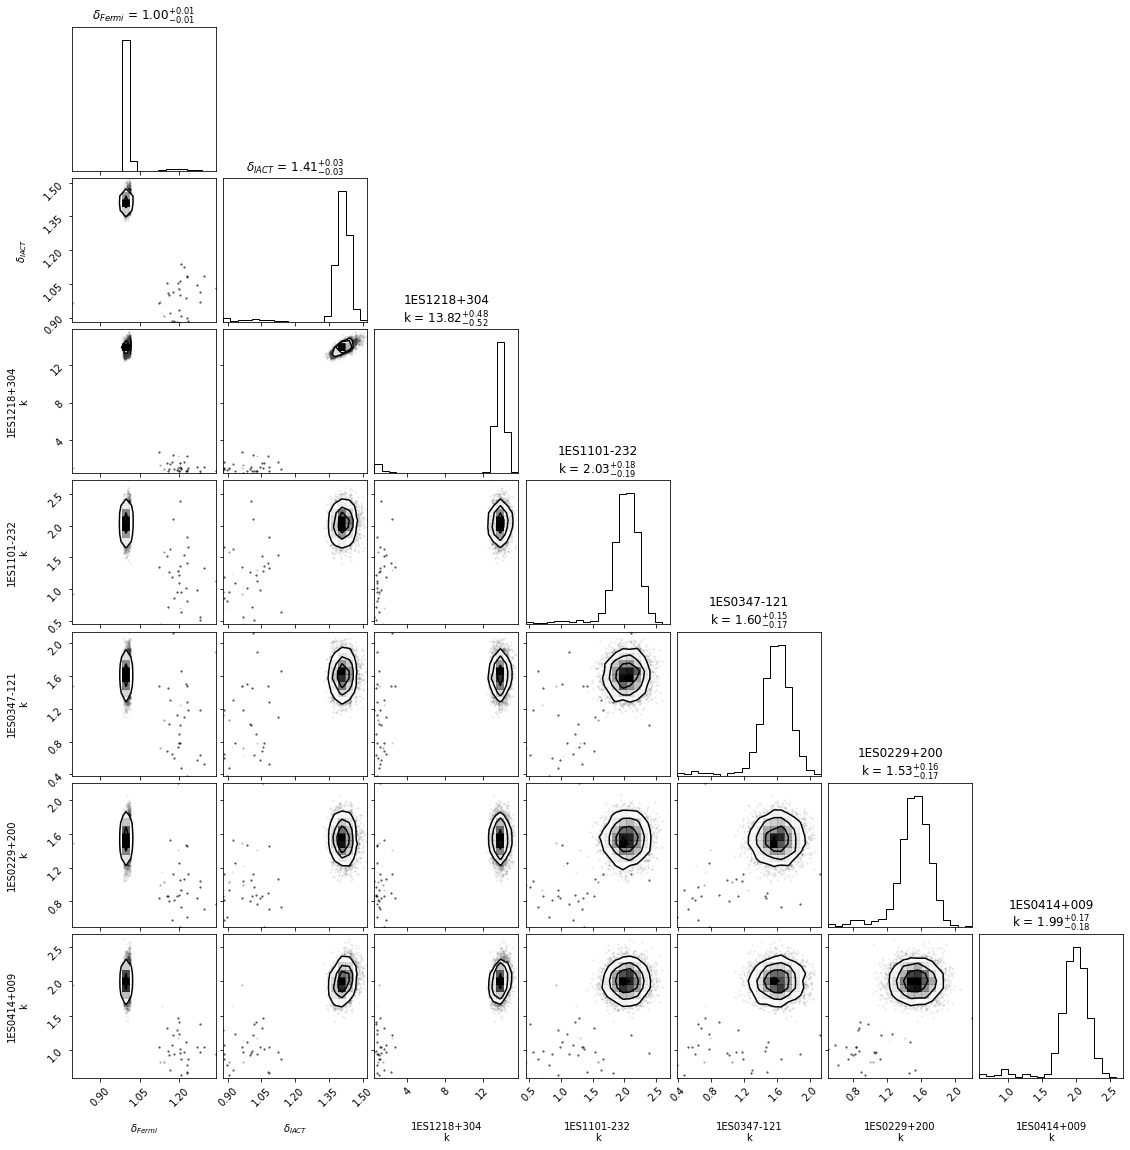

In [96]:
import corner

param_names = ['$\\delta_{{Fermi}}$', '$\\delta_{{IACT}}$'] + [
    f'{obj.name}\nk' for obj in exp.all_objects
]

figure = corner.corner(sample, labels=param_names, show_titles=True)